# Study of impact shifts in 2018 testbeam data
Use Impact_Shifts.txt file from Bruno Alves code  (TestBeamReconstruction)
Terms used :
 - shift : values from Impact_Shifts.txt, one shift for x and for y for each layer
 - diff : difference between rechit position and delay wire chamber (DWC) extrapolated position on HGCAL layer. Depends on the layer, but also on the event. (eventually combined with shift)


In [42]:
import pandas as pd
import uproot
import os
import awkward as ak
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
#%matplotlib widget
import mplhep as hep

In [4]:
os.system("/opt/exp_soft/cms/t3/eos-login -username tcuisset")

#Data 100 GeV
input_file = '/eos/cms/store/group/dpg_hgcal/tb_hgcal/2018/cern_h2_october/offline_analysis/ntuples/v16/ntuple_484.root'

# Simulation 100 GeV v3 (sim_proton)
#input_file = '/eos/cms/store/group/dpg_hgcal/tb_hgcal/2018/cern_h2_october/offline_analysis/sim_ntuples/CMSSW11_0_withAHCAL_newBeamline/FTFP_BERT_EMN/v3/electrons/ntuple_sim_config22_pdgID11_beamMomentum100_listFTFP_BERT_EMN_0000_1.root'

# Simulation 100 GeV v5 (sim_noproton)
#input_file = '/eos/cms/store/group/dpg_hgcal/tb_hgcal/2018/cern_h2_october/offline_analysis/sim_ntuples/CMSSW11_0_withAHCAL_newBeamline/FTFP_BERT_EMN/v5/electrons/ntuple_sim_config22_pdgID11_beamMomentum100_listFTFP_BERT_EMN_0000_1.root'

# Simulation 100 GeV v7 (with proton)
#input_file = '/eos/cms/store/group/dpg_hgcal/tb_hgcal/2018/cern_h2_october/offline_analysis/sim_ntuples/CMSSW11_0_withAHCAL_newBeamline/FTFP_BERT_EMN/v7_33m/electrons/ntuple_sim_config22_pdgID11_beamMomentum100_listFTFP_BERT_EMN_0000_1.root'

for array_i in uproot.iterate(input_file + ":trackimpactntupler/impactPoints", step_size="10MB", library="ak"):
    array_impact = array_i
    break

In [5]:
# Tune memory usage with step_size (real memeory usage is ~300 times step_size)
for array_i in uproot.iterate(input_file + ":rechitntupler/hits", step_size="30MB", library="ak",
    filter_name=["event", 'rechit_detid',
       'rechit_module', 'rechit_layer', 'rechit_chip', 'rechit_channel',
       'rechit_x', 'rechit_y', 'rechit_z', 'rechit_energy']):
    array_hits = array_i
    break

In [6]:
shift_map = { # File taken from Bruno Alves code. Previous provenance unknown. Maps layer-> (shiftX, shiftY)
1 : (-3.52216, 2.72417),
2 : (-3.62642, 2.71253),
3 : (-3.70279, 2.73514),
4 : (-3.68178, 2.69013),
5 : (-3.53902, 2.73582),
6 : (-3.60895, 2.7601),
7 : (-3.77711, 2.70275),
8 : (-3.78309, 2.70013),
9 : (-3.74654, 2.62871),
10 : (-3.79885, 2.64894),
11 : (-3.83036, 2.61498),
12 : (-3.85046, 2.61856),
13 : (-3.80845, 2.6431),
14 : (-3.88973, 2.57074),
15 : (-3.83787, 2.64904),
16 : (-3.93072, 2.62127),
17 : (-3.84896, 2.591),
18 : (-3.93918, 2.60614),
19 : (-3.918, 2.53426),
20 : (-3.96107, 2.5747),
21 : (-3.99221, 2.60619),
22 : (-4.03038, 2.62723),
23 : (-3.97634, 2.5293),
24 : (-3.98103, 2.59362),
25 : (-3.99045, 2.58746),
26 : (-4.02747, 2.57666),
27 : (-4.00032, 2.48522),
28 : (-3.95834, 2.49272),
}
#Put it in a dataframe
df_shifts = pd.DataFrame.from_dict(shift_map, orient="index", columns=["shiftX", "shiftY"]).rename_axis("layer")

#Map layer to z position
layer_to_z = {1: 13.8774995803833,
  2: 14.767499923706055,
  3: 16.782499313354492,
  4: 17.672500610351562,
  5: 19.6875,
  6: 20.577499389648438,
  7: 22.6924991607666,
  8: 23.582500457763672,
  9: 25.697500228881836,
  10: 26.587499618530273,
  11: 28.702499389648438,
  12: 29.592500686645508,
  13: 31.50749969482422,
  14: 32.397499084472656,
  15: 34.3125,
  16: 35.20249938964844,
  17: 37.11750030517578,
  18: 38.00749969482422,
  19: 39.92250061035156,
  20: 40.8125,
  21: 42.907501220703125,
  22: 44.037498474121094,
  23: 46.412498474121094,
  24: 47.54249954223633,
  25: 49.68199920654297,
  26: 50.6879997253418,
  27: 52.881500244140625,
  28: 53.903499603271484}


In [7]:
df_hits = ak.to_dataframe(array_hits, levelname=lambda i : {0 : "event_minus_one", 1:"rechit_id"}[i]).reset_index(level=1).reset_index(level=0, drop=True).set_index("event")
df_impact = ak.to_dataframe(array_impact, levelname=lambda i: {0 : "event_minus_one"}[i]).reset_index(drop=True).set_index("event")

In [8]:
df_full = pd.merge(df_hits, df_impact, on="event").set_index("rechit_id", append=True)

In [9]:
#Selections taken from Matteo Bonanomi : https://github.com/bonanomi/HGCALStandaloneAnalysis/blob/master/setup/reader.py
hit_sel = (
    (df_full.rechit_energy > 0.5) # Half-a-MIP cut
    # Kill faulty chips
    & (df_full.ntracks == 1) & (df_full.dwcReferenceType == 13)
    & ~((df_full.rechit_chip == 3) & (df_full.rechit_channel == 22)) & ~((df_full.rechit_module == 78) & (df_full.rechit_chip == 0)) & (((df_full.rechit_layer != 37) & (df_full.rechit_layer != 36)))
    # Select only events with good delay wire chamber information
    & (df_full.ntracks == 1) & (df_full.dwcReferenceType == 13)
)
hit_sel.value_counts()

True     3072879
False     307185
Name: count, dtype: int64

In [10]:
df_selected = df_full[hit_sel].copy()

## Compute barycenter of hits x and y using rechit_energy

In [11]:
# Compute x*energy
df_selected["rechit_EtX"] = df_selected["rechit_x"] * df_selected["rechit_energy"] # Energy times x position
df_selected["rechit_EtY"] = df_selected["rechit_y"] * df_selected["rechit_energy"]

#Use the shift map to shift positions before taking barycenter
df_selected_with_shifts = pd.merge(df_selected.reset_index(), df_shifts, left_on="rechit_layer", right_on="layer")
df_selected_with_shifts["rechit_EtX_shifted"] = (df_selected_with_shifts["rechit_x"] - df_selected_with_shifts["shiftX"]) * df_selected_with_shifts["rechit_energy"] # Energy times x position
df_selected_with_shifts["rechit_EtY_shifted"] = (df_selected_with_shifts["rechit_y"] - df_selected_with_shifts["shiftY"]) * df_selected_with_shifts["rechit_energy"]
df_selected_with_shifts


,event,rechit_id,rechit_detid,rechit_module,rechit_layer,rechit_chip,rechit_channel,rechit_x,rechit_y,rechit_z,...,m_x,m_y,b_x,b_y,rechit_EtX,rechit_EtY,shiftX,shiftY,rechit_EtX_shifted,rechit_EtY_shifted
0,2,9,16777341,78,1,2,32,-0.974487,2.812988,13.8775,...,-0.000432,0.000332,-1.428553,0.097662,-4.234540,12.223568,-3.52216,2.72417,11.070665,0.385951
1,2,10,16777342,78,1,2,40,-0.974487,1.687744,13.8775,...,-0.000432,0.000332,-1.428553,0.097662,-5.420848,9.388531,-3.52216,2.72417,14.172115,-5.765398
2,2,15,16777405,78,1,1,40,-1.948975,2.250488,13.8775,...,-0.000432,0.000332,-1.428553,0.097662,-43.836632,50.618324,-3.52216,2.72417,35.384324,-10.654121
3,2,20,16777468,78,1,1,10,-2.923340,2.812988,13.8775,...,-0.000432,0.000332,-1.428553,0.097662,-4.886775,4.702307,-3.52216,2.72417,1.001012,0.148472
4,2,21,16777469,78,1,1,42,-2.923340,1.687744,13.8775,...,-0.000432,0.000332,-1.428553,0.097662,-3.648671,2.106503,-3.52216,2.72417,0.747398,-1.293581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2943043,4604,723,469766143,144,28,2,40,0.974487,1.687744,53.9035,...,-0.000476,0.000329,-2.486228,0.734693,1.137718,1.970449,-3.95834,2.49272,5.759099,-0.939813
2943044,4605,689,469762234,144,28,2,6,-1.948975,5.625977,53.9035,...,-0.000255,0.000537,-2.234627,1.664717,-0.976350,2.818365,-3.95834,2.49272,1.006603,1.569623
2943045,4606,682,469762235,144,28,2,4,-1.948975,4.500977,53.9035,...,-0.000282,0.001053,-2.010417,1.539969,-1.304201,3.011931,-3.95834,2.49272,1.344613,1.343871
2943046,4606,685,469766019,144,28,0,16,1.948975,-2.250488,53.9035,...,-0.000282,0.001053,-2.010417,1.539969,4.453503,-5.142477,-3.95834,2.49272,13.498505,-10.838464


In [12]:
# Make barycenter per event and layer
barycenter_event_df = df_selected_with_shifts.groupby(["event", "rechit_layer"]).agg(
    rechit_EtX_sum=pd.NamedAgg(column="rechit_EtX", aggfunc="sum"), # Sum energy*x
    rechit_EtY_sum=pd.NamedAgg(column="rechit_EtY", aggfunc="sum"),
    rechit_EtX_shifted_sum=pd.NamedAgg(column="rechit_EtX_shifted", aggfunc="sum"), # Same but for shifted positions
    rechit_EtY_shifted_sum=pd.NamedAgg(column="rechit_EtY_shifted", aggfunc="sum"),
    rechit_E_sum=pd.NamedAgg(column="rechit_energy", aggfunc="sum"), # Sum energy (for normalization)
).rename_axis(index={"rechit_layer":"layer"})
# Compute the actual barycenters
barycenter_event_df["layer_x_barycenter"] = barycenter_event_df.rechit_EtX_sum / barycenter_event_df.rechit_E_sum
barycenter_event_df["layer_y_barycenter"] = barycenter_event_df.rechit_EtY_sum / barycenter_event_df.rechit_E_sum
barycenter_event_df["layer_x_shifted_barycenter"] = barycenter_event_df.rechit_EtX_shifted_sum / barycenter_event_df.rechit_E_sum
barycenter_event_df["layer_y_shifted_barycenter"] = barycenter_event_df.rechit_EtY_shifted_sum / barycenter_event_df.rechit_E_sum
barycenter_event_df

rechit_EtX_sum  rechit_EtY_sum  rechit_EtX_shifted_sum   
event layer                                                           
2     1          -67.943825       83.202316               63.342450  \
      2         -126.008133      132.330109               79.692366   
      3         -393.651367      408.834229              209.858053   
      4         -473.394135      492.985809              295.037927   
      5         -529.561707      621.040833              351.506098   
...                     ...             ...                     ...   
4606  24         -42.516903       15.560375               17.976493   
      25           3.862362       -6.689944                9.134607   
      26          -7.451100       -5.781733                0.385822   
      27           6.674763       -4.539017               15.068609   
      28           3.923438       -2.577494               18.761770   

             rechit_EtY_shifted_sum  rechit_E_sum  layer_x_barycenter   
event layer                                                             
2     1                  -18.339389     37.274364           -1.822803  \
      2                  -21.532054     56.722748           -2.221474   
      3                  -36.960107    162.987747           -2.415220   
      4                  -68.476900    208.712112           -2.268168   
      5                  -60.063796    248.958130           -2.127111   
...                             ...           ...                 ...   
4606  24                 -23.850750     15.195413           -2.798009   
      25                 -10.108537      1.321216            2.923340   
      26                 -10.795571      1.945867           -3.829192   
      27                  -9.753738      2.098294            3.181044   
      28                 -11.921767      3.748625            1.046634   

             layer_y_barycenter  layer_x_shifted_barycenter   
event layer                                                   
2     1                2.232159                    1.699357  \
      2                2.332928                    1.404945   
      3                2.508374                    1.287570   
      4                2.362037                    1.413612   
      5                2.494559                    1.411908   
...                         ...                         ...   
4606  24               1.024018                    1.183021   
      25              -5.063477                    6.913790   
      26              -2.971288                    0.198278   
      27              -2.163194                    7.181364   
      28              -0.687584                    5.004974   

             layer_y_shifted_barycenter  
event layer                              
2     1                       -0.492011  
      2                       -0.379602  
      3                       -0.226766  
      4                       -0.328093  
      5                       -0.241261  
...                                 ...  
4606  24                      -1.569602  
      25                      -7.650937  
      26                      -5.547948  
      27                      -4.648415  
      28                      -3.180304  

[124999 rows x 9 columns]

In [11]:
pd.set_option('display.min_rows', 100)
df_impact

,run,ntracks,impactX_HGCal_layer_1,impactY_HGCal_layer_1,impactX_HGCal_layer_2,impactY_HGCal_layer_2,impactX_HGCal_layer_3,impactY_HGCal_layer_3,impactX_HGCal_layer_4,impactY_HGCal_layer_4,...,impactY_HGCal_layer_93,impactX_HGCal_layer_94,impactY_HGCal_layer_94,trackChi2_X,trackChi2_Y,dwcReferenceType,m_x,m_y,b_x,b_y
event,,,,,,,,,,,,,,,,,,,,,
1,0,1,-1.962988,1.405270,-1.972507,1.400126,-1.994057,1.388478,-2.003575,1.383334,...,-999.0,-999.0,-999.0,0.011428,1.275474e-01,13,-0.010695,-0.005780,-1.814569,1.485488
2,0,1,-2.348212,1.035237,-2.357691,1.030099,-2.379151,1.018465,-2.388629,1.013327,...,-999.0,-999.0,-999.0,6.025321,1.912737e-01,13,-0.010650,-0.005773,-2.200416,1.115357
3,0,1,-1.813584,1.594926,-1.823061,1.589752,-1.844515,1.578038,-1.853992,1.572864,...,-999.0,-999.0,-999.0,0.135932,5.773767e-01,13,-0.010648,-0.005814,-1.665822,1.675603
4,0,1,-2.245314,1.757290,-2.254786,1.752127,-2.276231,1.740438,-2.285703,1.735275,...,-999.0,-999.0,-999.0,0.846254,8.105902e-02,13,-0.010643,-0.005801,-2.097621,1.837794
5,0,1,-1.602198,2.194934,-1.611668,2.189797,-1.633108,2.178166,-1.642578,2.173029,...,-999.0,-999.0,-999.0,1.061226,2.827026e+00,13,-0.010640,-0.005772,-1.454538,2.275036
6,0,1,-1.591003,2.197643,-1.600480,2.192504,-1.621935,2.180870,-1.631411,2.175732,...,-999.0,-999.0,-999.0,0.022361,3.841878e+00,13,-0.010648,-0.005774,-1.443240,2.277767
7,0,1,-2.062279,1.887614,-2.071738,1.882465,-2.093155,1.870805,-2.102614,1.865655,...,-999.0,-999.0,-999.0,1.210072,3.700681e-03,13,-0.010629,-0.005786,-1.914781,1.967916
8,0,1,-1.333042,1.668280,-1.342545,1.663147,-1.364059,1.651525,-1.373561,1.646392,...,-999.0,-999.0,-999.0,1.812813,2.098925e+00,13,-0.010677,-0.005768,-1.184872,1.748323
9,0,1,-1.842097,1.226504,-1.851566,1.221317,-1.873006,1.209573,-1.882475,1.204386,...,-999.0,-999.0,-999.0,0.173833,1.088484e+00,13,-0.010640,-0.005828,-1.694440,1.307384


In [13]:
def shiftCol(df:pd.DataFrame, colName_head:str, x_or_y):
    """ Apply a shift (with minus sign) on all columns of the name colName_headi where i is all layers
    x_or_y : 0 for x, 1 for y"""
    for i in range(1, 29):
        # Note the minus one
        df["shifted_"+colName_head+str(i)] = - 1 * df[colName_head+str(i)] + shift_map[i][x_or_y]

def melt(df, colName_head, outColName):
    """ Transform all impactX_HGCal_layer_i columns into rows"""
    return (df[[colName_head+str(i) for i in range(1, 29)]]
        .reset_index()
        .melt(id_vars="event", var_name="layer", value_name=outColName)
        .set_index(["event", "layer"])
        .rename(index={colName_head+str(i) : i for i in range(1, 29)})
        .sort_index()
    )

In [14]:
df_impact_layer = melt(df_impact, "impactX_HGCal_layer_", "impactX")
df_impact_layer["impactY"] = melt(df_impact, "impactY_HGCal_layer_", "impactY")
shiftCol(df_impact, "impactX_HGCal_layer_", 0)
shiftCol(df_impact, "impactY_HGCal_layer_", 1)
df_impact_layer["impactX_shifted"] = melt(df_impact, "shifted_impactX_HGCal_layer_", "impactX_shifted")
df_impact_layer["impactY_shifted"] = melt(df_impact, "shifted_impactY_HGCal_layer_", "impactY_shifted")
df_impact_layer

impactX     impactY  impactX_shifted  impactY_shifted
event layer                                                          
1     1     -999.000000 -999.000000       995.477844      1001.724182
      2     -999.000000 -999.000000       995.373596      1001.712524
      3     -999.000000 -999.000000       995.297180      1001.735168
      4     -999.000000 -999.000000       995.318237      1001.690125
      5     -999.000000 -999.000000       995.460999      1001.735840
...                 ...         ...              ...              ...
10734 24      -1.674456    0.215750        -2.306574         2.377870
      25      -1.675440    0.216038        -2.315010         2.371422
      26      -1.675903    0.216174        -2.351567         2.360486
      27      -1.676913    0.216469        -2.323407         2.268751
      28      -1.677383    0.216607        -2.280957         2.276113

[300552 rows x 4 columns]

In [15]:
barycenter_impact_df = pd.merge(barycenter_event_df, df_impact_layer, left_index=True, right_index=True)
# Make barycenter of hits then substract impact
barycenter_impact_df["bary_impact_diff_x"] = barycenter_impact_df["layer_x_barycenter"] - barycenter_impact_df["impactX"]
barycenter_impact_df["bary_impact_diff_y"] = barycenter_impact_df["layer_y_barycenter"] - barycenter_impact_df["impactY"]

# Make barycenter of hits then substract shifted impact (cross-check for bary_impact_diff_x_shiftedBefore_plus, is the same)
# Here we use a minus but because there is another minus that was already applied when impactX_shifted was constructed
barycenter_impact_df["bary_impact_diff_x_shiftedAfter"] = barycenter_impact_df["layer_x_barycenter"] - barycenter_impact_df["impactX_shifted"]
barycenter_impact_df["bary_impact_diff_y_shiftedAfter"] = barycenter_impact_df["layer_y_barycenter"] - barycenter_impact_df["impactY_shifted"]

# Shift positions of hits then barycenter then substract impact
## _plus : *add* impactX : seems to work but very weird
barycenter_impact_df["bary_impact_diff_x_shiftedBefore_plus"] = barycenter_impact_df["layer_x_shifted_barycenter"] + barycenter_impact_df["impactX"]
barycenter_impact_df["bary_impact_diff_y_shiftedBefore_plus"] = barycenter_impact_df["layer_y_shifted_barycenter"] + barycenter_impact_df["impactY"]

## _plus : *substract* impactX : what would seem the correct way to do it but does not get the correct results
barycenter_impact_df["bary_impact_diff_x_shiftedBefore_minus"] = barycenter_impact_df["layer_x_shifted_barycenter"] - barycenter_impact_df["impactX"]
barycenter_impact_df["bary_impact_diff_y_shiftedBefore_minus"] = barycenter_impact_df["layer_y_shifted_barycenter"] - barycenter_impact_df["impactY"]


barycenter_impact_df

rechit_EtX_sum  rechit_EtY_sum  rechit_EtX_shifted_sum   
event layer                                                           
2     1          -67.943825       83.202316               63.342450  \
      2         -126.008133      132.330109               79.692366   
      3         -393.651367      408.834229              209.858053   
      4         -473.394135      492.985809              295.037927   
      5         -529.561707      621.040833              351.506098   
...                     ...             ...                     ...   
4606  24         -42.516903       15.560375               17.976493   
      25           3.862362       -6.689944                9.134607   
      26          -7.451100       -5.781733                0.385822   
      27           6.674763       -4.539017               15.068609   
      28           3.923438       -2.577494               18.761770   

             rechit_EtY_shifted_sum  rechit_E_sum  layer_x_barycenter   
event layer                                                             
2     1                  -18.339389     37.274364           -1.822803  \
      2                  -21.532054     56.722748           -2.221474   
      3                  -36.960107    162.987747           -2.415220   
      4                  -68.476900    208.712112           -2.268168   
      5                  -60.063796    248.958130           -2.127111   
...                             ...           ...                 ...   
4606  24                 -23.850750     15.195413           -2.798009   
      25                 -10.108537      1.321216            2.923340   
      26                 -10.795571      1.945867           -3.829192   
      27                  -9.753738      2.098294            3.181044   
      28                 -11.921767      3.748625            1.046634   

             layer_y_barycenter  layer_x_shifted_barycenter   
event layer                                                   
2     1                2.232159                    1.699357  \
      2                2.332928                    1.404945   
      3                2.508374                    1.287570   
      4                2.362037                    1.413612   
      5                2.494559                    1.411908   
...                         ...                         ...   
4606  24               1.024018                    1.183021   
      25              -5.063477                    6.913790   
      26              -2.971288                    0.198278   
      27              -2.163194                    7.181364   
      28              -0.687584                    5.004974   

             layer_y_shifted_barycenter   impactX  ...  impactX_shifted   
event layer                                        ...                    
2     1                       -0.492011 -1.434545  ...        -2.087615  \
      2                       -0.379602 -1.434929  ...        -2.191491   
      3                       -0.226766 -1.435799  ...        -2.266991   
      4                       -0.328093 -1.436183  ...        -2.245597   
      5                       -0.241261 -1.437053  ...        -2.101967   
...                                 ...       ...  ...              ...   
4606  24                      -1.569602 -2.023841  ...        -1.957189   
      25                      -7.650937 -2.024445  ...        -1.966005   
      26                      -5.547948 -2.024729  ...        -2.002741   
      27                      -4.648415 -2.025349  ...        -1.974971   
      28                      -3.180304 -2.025637  ...        -1.932703   

             impactY_shifted  bary_impact_diff_x  bary_impact_diff_y   
event layer                                                            
2     1             2.621900           -0.388258            2.129889  \
      2             2.609964           -0.786546            2.230363   
      3             2.631906           -0.979422       

In [45]:
def makePlots(plot_df, varName):
    fig, axes = plt.subplots(6, 5, figsize=(64/3, 48/3), dpi=300, sharex=True, sharey=False)
    flat_axes= np.array(axes).flatten()
    for layer in range(1, 28):
        ax = flat_axes[layer-1]
        df_cur_layer = plot_df[plot_df.layer == layer]
        df_cur_layer[varName].plot(kind="hist", weights=df_cur_layer.rechit_E_sum, bins=100, ax=ax, fill=False, histtype='step', label="unshifted")
        df_cur_layer[varName+"_shiftedBefore_plus"].plot(kind="hist", weights=df_cur_layer.rechit_E_sum, bins=100, ax=ax, fill=False, histtype='step', label="shifted before bary (+impact)")
        df_cur_layer[varName+"_shiftedBefore_minus"].plot(kind="hist", weights=df_cur_layer.rechit_E_sum, bins=100, ax=ax, fill=False, histtype='step', label="shifted before bary (-impact)")
        
        # Cross-check : should be exactly the same as varName+"_shiftedBefore_plus"
        #df_cur_layer[varName+"_shiftedAfter"].plot(kind="hist", weights=df_cur_layer.rechit_E_sum, bins=100, ax=ax, fill=False, histtype='step', label="shifted after bary (+impact)")
        ax.set_title("Layer=" + str(layer))
        ax.set_xlabel(varName+" (cm)")
    handles, labels = flat_axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='right')
def makeSinglePlot(plot_df, layer, varName):
    fig, ax = plt.subplots()
    df_cur_layer = plot_df[plot_df.layer == layer]
    df_cur_layer[varName].plot(kind="hist", weights=df_cur_layer.rechit_E_sum, bins=100, ax=ax, fill=False, histtype='step', label="Unshifted")
    df_cur_layer[varName+"_shiftedBefore_plus"].plot(kind="hist", weights=df_cur_layer.rechit_E_sum, bins=100, ax=ax, fill=False, histtype='step', label="Shifted")
    #df_cur_layer[varName+"_shiftedBefore_minus"].plot(kind="hist", weights=df_cur_layer.rechit_E_sum, bins=100, ax=ax, fill=False, histtype='step', label="shifted before bary (-impact)")
    
    # Cross-check : should be exactly the same as varName+"_shiftedBefore_plus"
    #df_cur_layer[varName+"_shiftedAfter"].plot(kind="hist", weights=df_cur_layer.rechit_E_sum, bins=100, ax=ax, fill=False, histtype='step', label="shifted after bary (+impact)")
    #ax.set_title("Layer=" + str(layer))
    ax.set_xlabel("Difference between DWC impact position and barycenter of hits in x (cm)")
    ax.set_ylabel("Sum of rechits energies on layer (GeV)")
    ax.set_xlim(-4, 4)
    hep.cms.text("Preliminary", ax=ax)
    #hep.cms.text("Simulation Preliminary", ax=main_ax)
    beamEnergy=100
    hep.cms.lumitext(f"Layer {layer} - $e^+$ {str(beamEnergy)} GeV", ax=ax)
    ax.legend()


KeyboardInterrupt: 

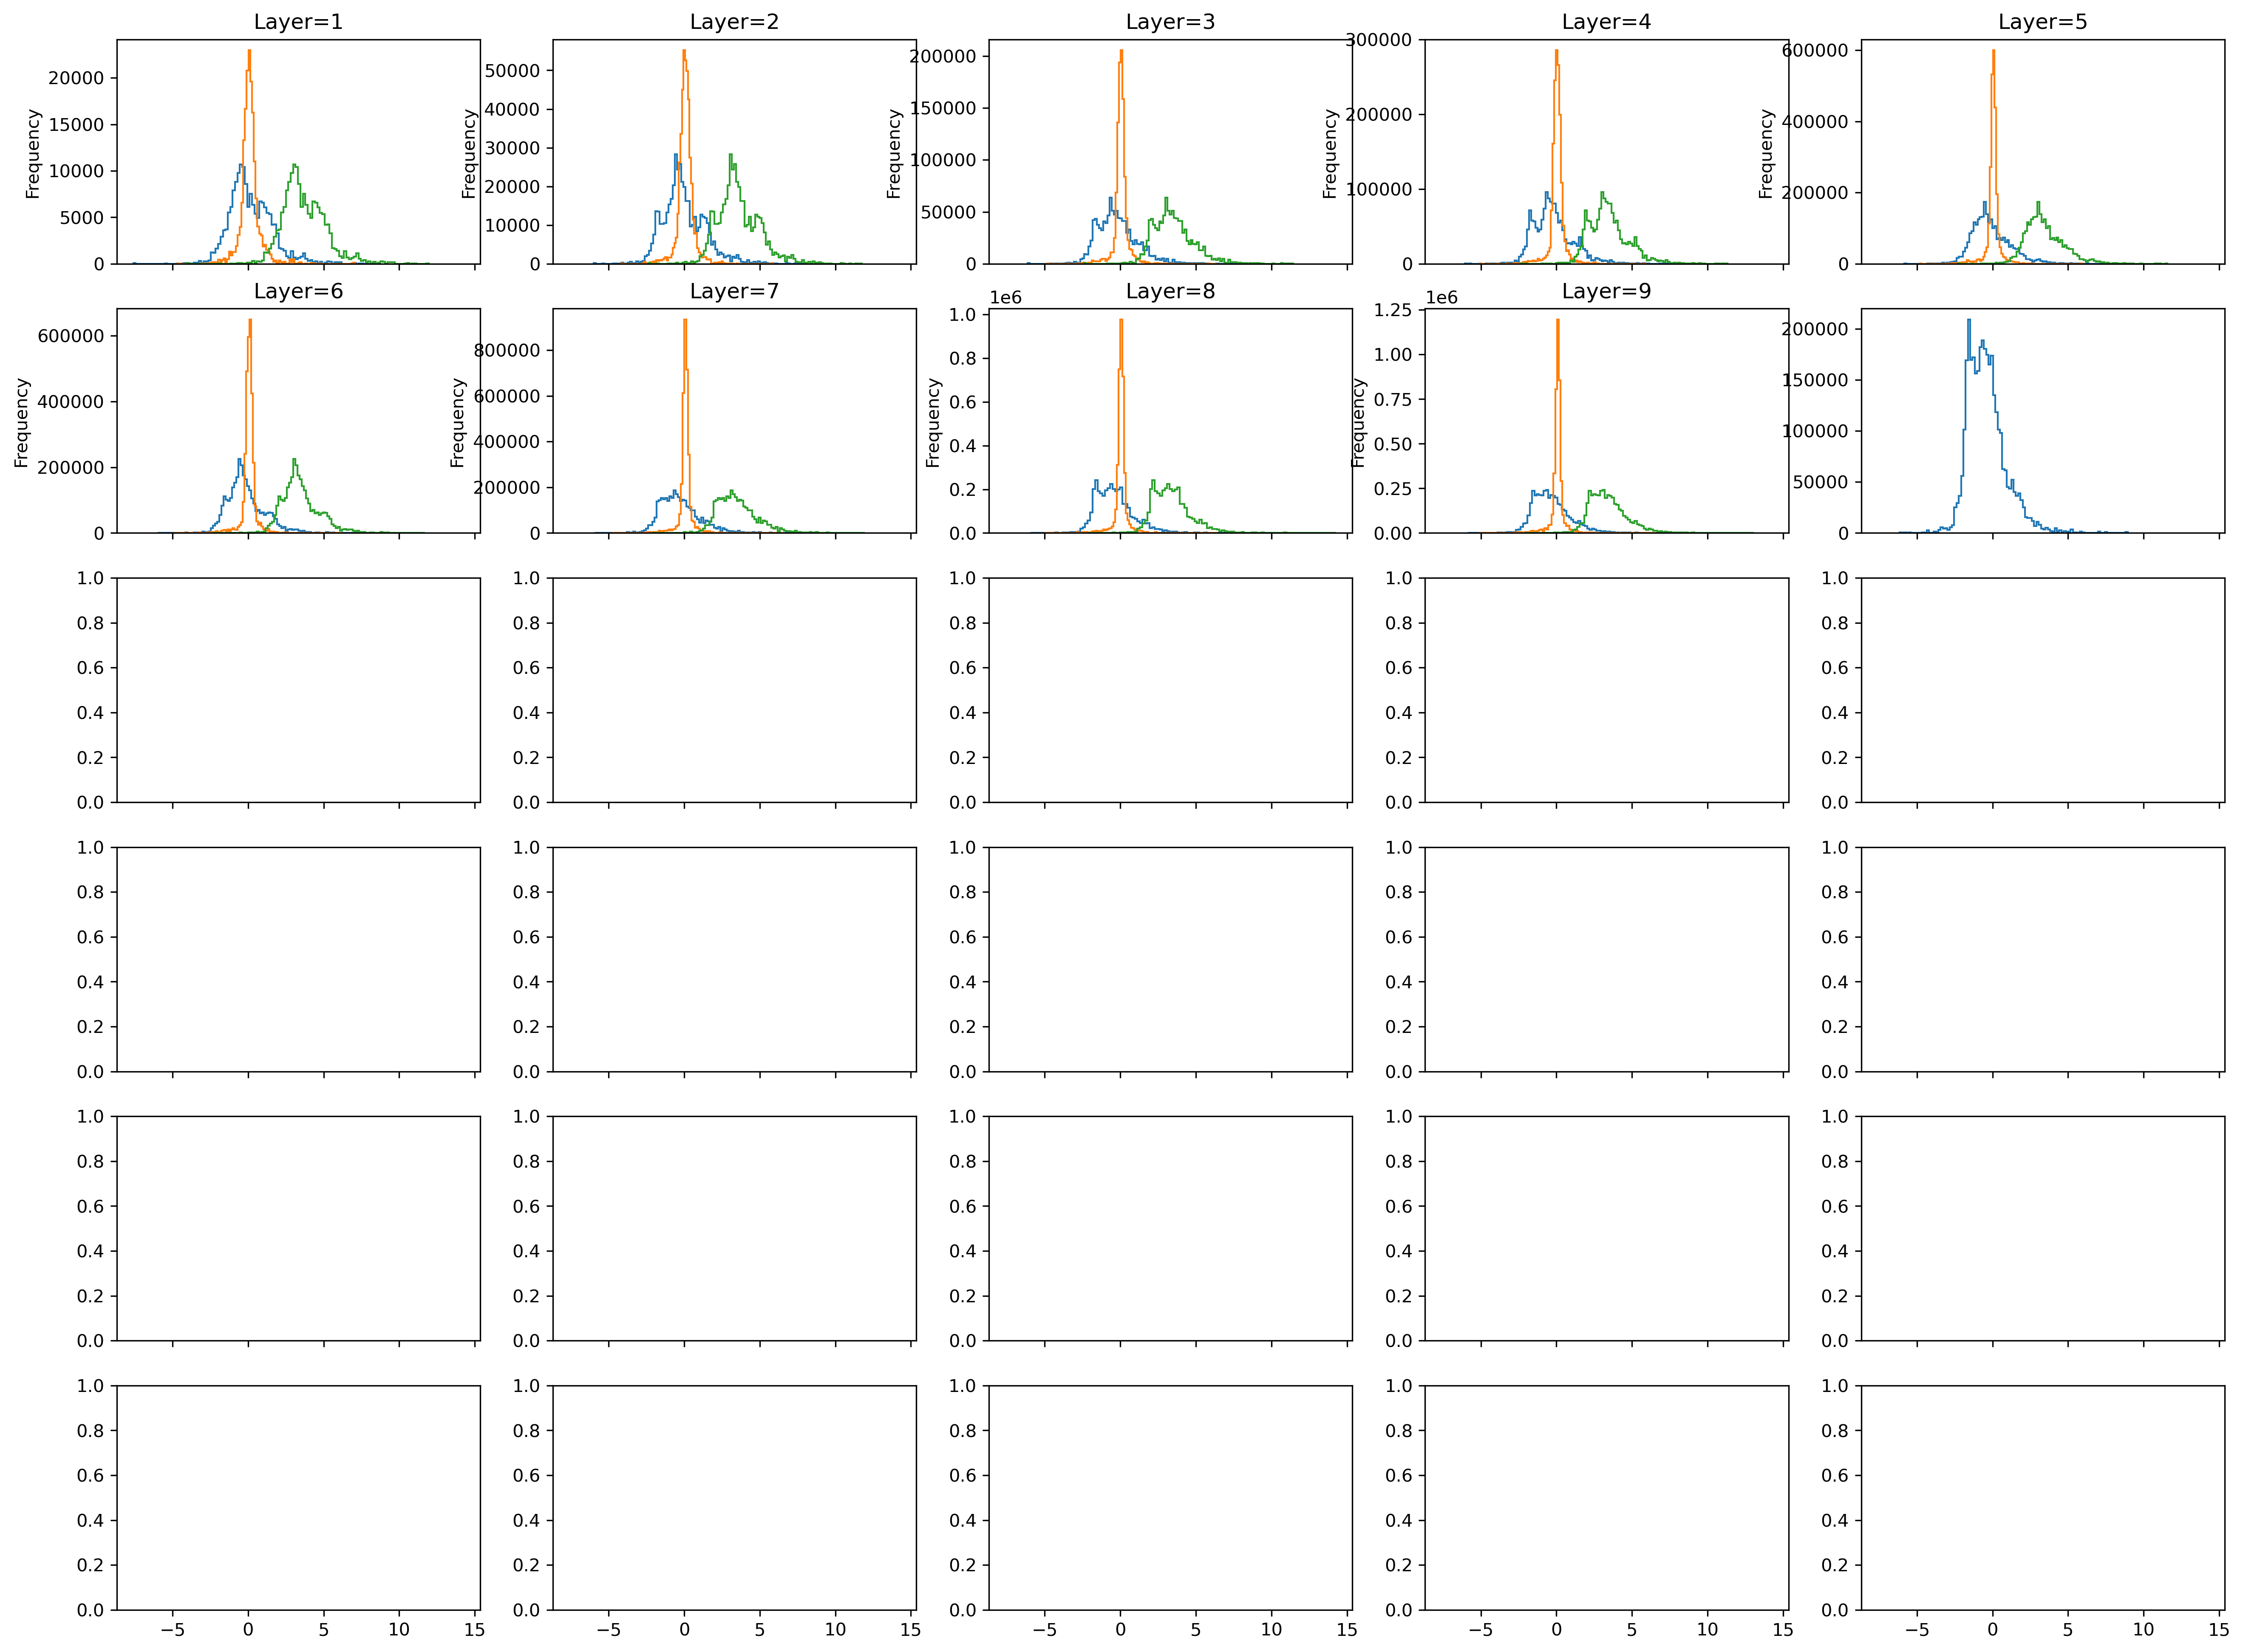

In [21]:
plot_df = barycenter_impact_df.reset_index(level="layer")
#plot_df = plot_df[plot_df.rechit_E_sum > 100]
makePlots(plot_df, "bary_impact_diff_x")

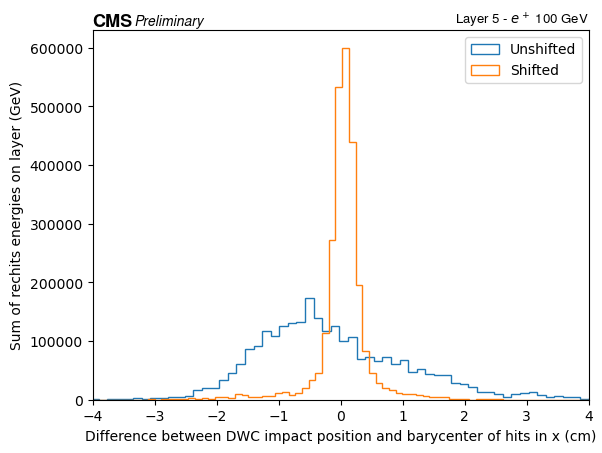

In [46]:
makeSinglePlot(plot_df, 5, "bary_impact_diff_x",)

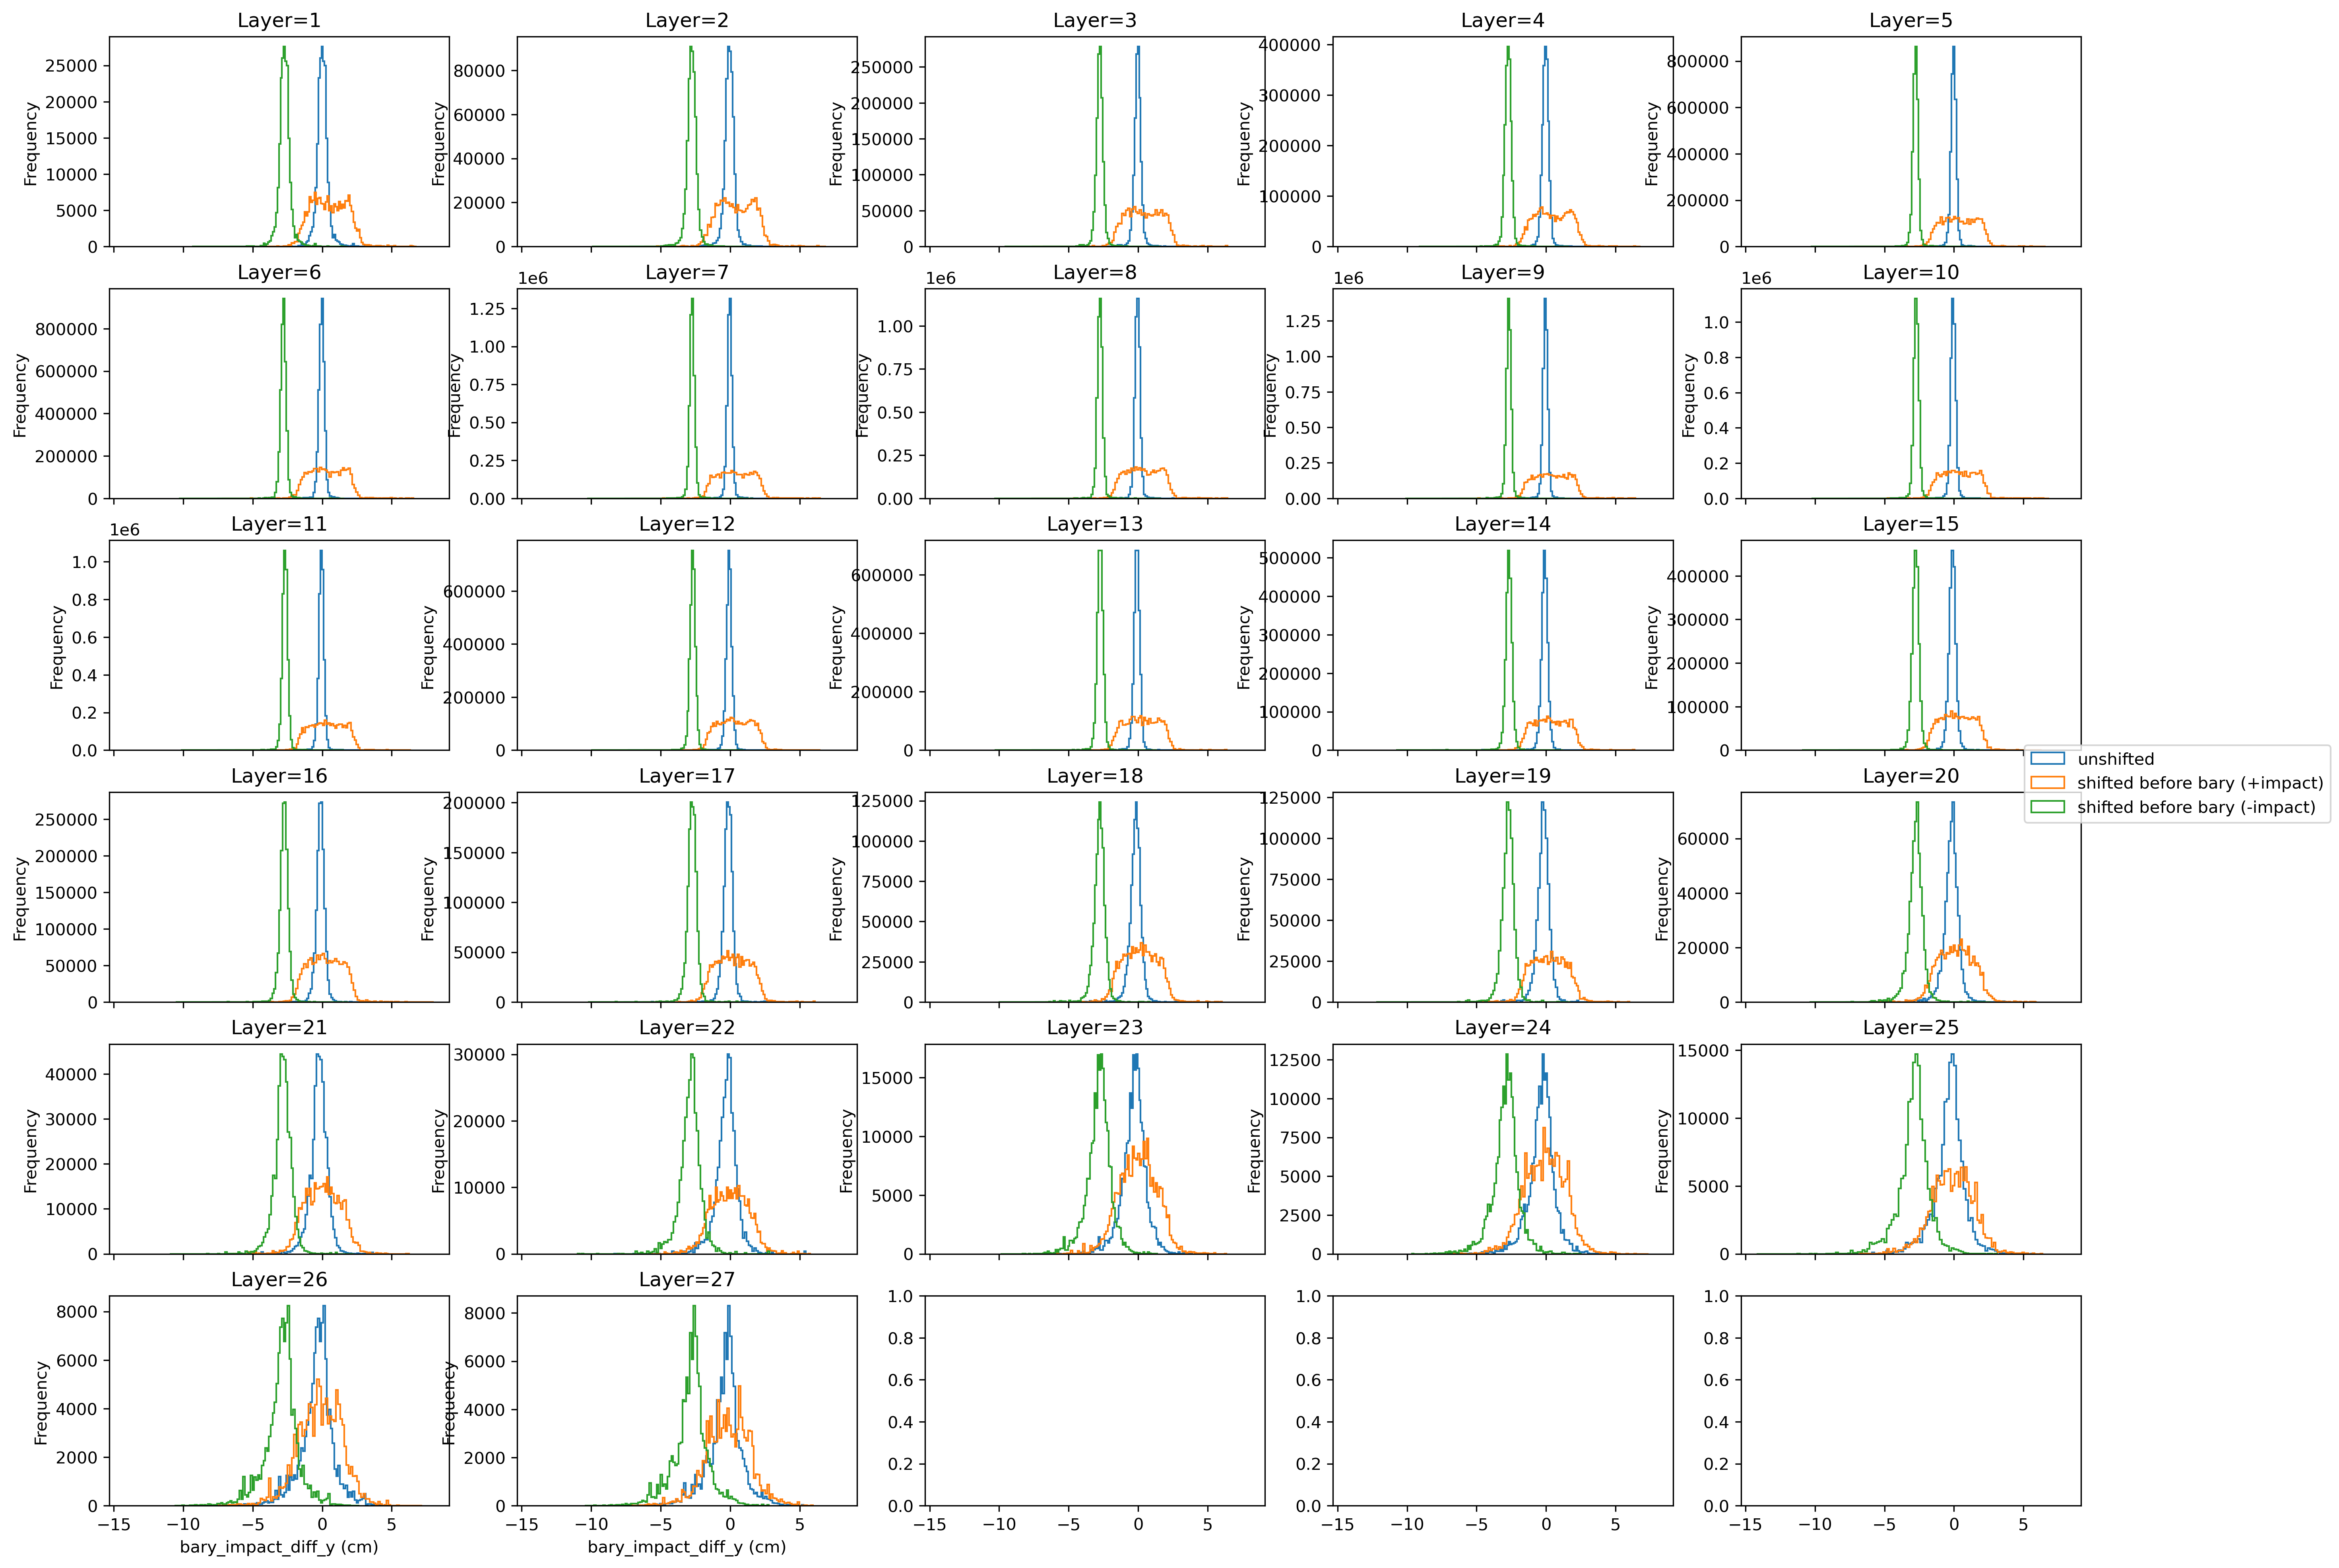

In [17]:
makePlots(plot_df, "bary_impact_diff_y")

In [19]:
barycenter_impact_df[["bary_impact_diff_x", "bary_impact_diff_y", 
    "bary_impact_diff_x_shiftedBefore_minus", "bary_impact_diff_y_shiftedBefore_minus",
    "bary_impact_diff_x_shiftedBefore_plus", "bary_impact_diff_y_shiftedBefore_plus"]].groupby("layer").mean()

,bary_impact_diff_x,bary_impact_diff_y,bary_impact_diff_x_shiftedBefore_minus,bary_impact_diff_y_shiftedBefore_minus,bary_impact_diff_x_shiftedBefore_plus,bary_impact_diff_y_shiftedBefore_plus
layer,,,,,,
1,0.077924,0.008894,3.600084,-2.715276,-0.310571,0.514529
2,0.079772,-0.057887,3.706192,-2.770417,-0.225244,0.450141
3,0.054991,-0.049194,3.757781,-2.784334,-0.216473,0.411713
4,0.062774,-0.047382,3.744554,-2.737512,-0.248928,0.448559
5,0.053171,-0.041913,3.592191,-2.777733,-0.443753,0.384846
6,0.070027,-0.048064,3.678977,-2.808164,-0.375562,0.344438
7,0.062514,-0.048223,3.839624,-2.750973,-0.261032,0.377543
8,0.083178,-0.054737,3.866268,-2.754867,-0.254164,0.362655
9,0.084000,-0.056751,3.830540,-2.685461,-0.334388,0.408189
